This notebook learns both a forward and a reverse model of the suction cup mechanics. Here, we make the following design decisions.

Forward model: from a minimum displacement to aligned, predict the capacitance measurements
Inverse model: from the capacitance measurements, predict the minimum displacement needed to align

- Measurement snapshots, not a steam of data
- Use each time sample at a particular pose as an additional data point
- 

## Inverse Model

In [1]:
%matplotlib widget
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import serial_data_formatter as sdf

The annotations file must be in the format
[file_name_str], [label]

In our case, the label is the displacement necessary to minimally align the suction cup with the box. 

In [139]:
class CapacitanceDataset(Dataset):
    def __init__(self, ground_truth_file, cap_file, cup, box, transform=None, target_transform=None):
        self.ground_truth = pd.read_csv(ground_truth_file)
        self.cup = cup
        self.box = box
        self.displacements = self.calculate_minimum_displacements()
        self.serial_data = sdf.SerialData(cap_file)
        # self.cap_data, self.displacements = self.extract_segment_data()
        self.cap_data, self.displacements = self.extract_average_segment_data()
        self.transform = transform
        self.target_transform = target_transform
    
    def calculate_minimum_displacements(self):
        displacements = []
        for idx, row in self.ground_truth.iterrows():
            if row["label"] == "aligned":
                displacements.append((0,0))
                # self.ground_truth.at[idx, 'displacement'] = (0, 0)
            elif row["label"] == "edge_misaligned":
                # Check if x out of bounds
                x_lim = self.box.x_size / 2 - self.cup.diameter / 2
                y_lim = self.box.y_size / 2 - self.cup.diameter / 2
                if abs(row["x"]) > x_lim:
                    # self.ground_truth.at[idx, "displacement"] = (np.sign(row["x"]) * (x_lim - row["x"]), 0)
                    displacements.append((np.sign(row["x"]) * x_lim - row["x"], 0))
                else:
                    # self.ground_truth.at[idx, 'displacement'] = (0, np.sign(row["y"]) * (y_lim - row["y"]))
                    displacements.append((0, np.sign(row["y"]) * y_lim - row["y"]))
            elif row["label"] == "corner_misaligned":
                x_lim = self.box.x_size / 2 - self.cup.diameter / 2
                y_lim = self.box.y_size / 2 - self.cup.diameter / 2
                # self.ground_truth.at[idx, 'displacement'] = (np.sign(row["x"]) * (x_lim - row["x"]), np.sign(row["y"]) * (y_lim - row["y"]))
                displacements.append((np.sign(row["x"]) * x_lim - row["x"], np.sign(row["y"]) * y_lim - row["y"]))
        return np.array(displacements)
    
    def extract_segment_data(self):
        cap_data = self.serial_data.cap_counts[self.serial_data.actuations==0]
        cap_data = cap_data - np.mean(cap_data[self.serial_data.segment_ends[0]], axis=0)
        segment_lengths = self.serial_data.segment_ends - self.serial_data.segment_starts
        segment_lengths = np.r_[segment_lengths, len(self.serial_data.cap_counts) - self.serial_data.actuation_ends[-1] + 1]
        
        actuation_displacements = self.displacements
        zero_displacements = np.zeros((len(actuation_displacements)+1, 2))

        combined_displacements = np.empty((len(actuation_displacements)+len(zero_displacements),2))
        combined_displacements[0::2] = zero_displacements
        combined_displacements[1::2] = actuation_displacements
        displacements = np.repeat(combined_displacements, segment_lengths, axis=0)

        return cap_data.astype(np.float32), displacements.astype(np.float32)
    
    def extract_average_segment_data(self):
        cap_data = self.serial_data.cap_counts
        cap_data = cap_data - np.mean(cap_data[self.serial_data.segment_ends[0]], axis=0)

        cap_averages = np.array([
            np.mean(cap_data[start:end], axis=0)
            for start, end in zip(self.serial_data.segment_starts, self.serial_data.segment_ends)
        ])[1::2]
        print(cap_averages.shape)
        print(self.displacements.shape)
        return cap_averages.astype(np.float32), self.displacements.astype(np.float32)
    
    def get_segment_time_series(self, idx):
        """Get the time series of the idxth actuated segment"""
        cap_data = self.serial_data.cap_counts
        cap_data = cap_data - np.mean(cap_data[self.serial_data.segment_ends[0]], axis=0)

        start_index = self.serial_data.segment_starts[2*idx + 1] - 200
        end_index = self.serial_data.segment_ends[2*idx + 1] + 200
        return self.serial_data.time[start_index:end_index], cap_data[start_index:end_index]

        

    def __len__(self):
        return len(self.cap_data)
    
    def __getitem__(self, idx):
        return self.cap_data[idx], self.displacements[idx]
        # return self.displacements[idx], self.cap_data[idx]

In [140]:
from offset_generator import Box, SuctionCup

# Build dataset
box = Box(x_size=100, y_size=100)
cup = SuctionCup(diameter=40, lip_to_board_height=6.7, max_actuation=5)
ground_truth_path = "data/translation_gt/251016_1357_randomTranslation_1000x_40mm_gt.csv"
cap_data_path = "data/translation_gt/251016_1357_randomTranslation_1000x_40mm.csv"
cap_dataset = CapacitanceDataset(ground_truth_path, cap_data_path, cup, box, transform=ToTensor())

serial_data = sdf.SerialData(cap_data_path)

(3000, 8)
(3000, 2)


Text(0.5, 1.0, 'First Actuation')

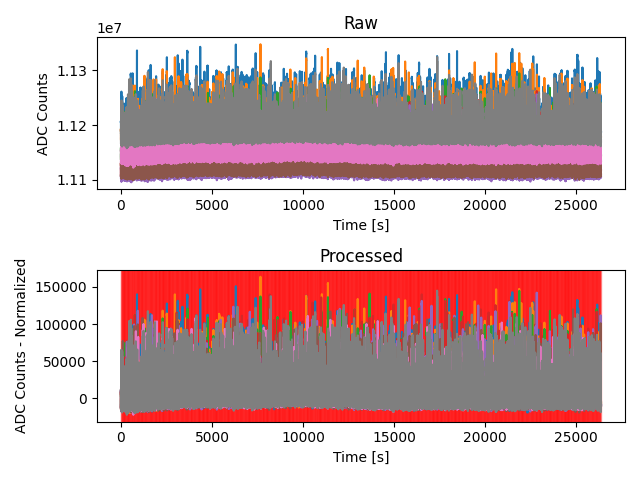

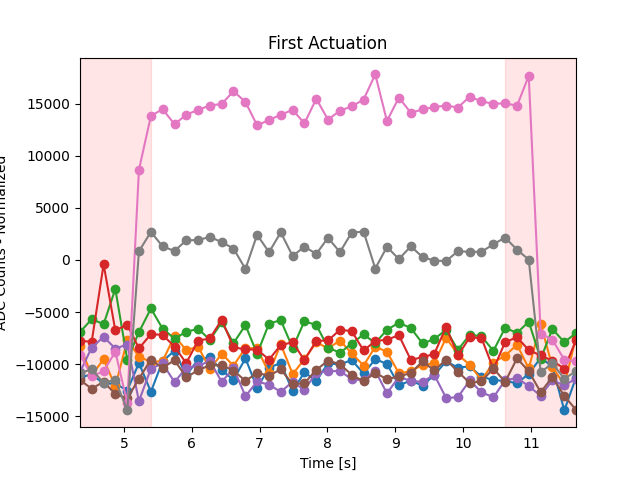

In [149]:
fig, axs = plt.subplots(2)
axs[0].plot(serial_data.time, serial_data.cap_counts)
axs[0].set_xlabel("Time [s]")
axs[0].set_ylabel("ADC Counts")
axs[0].set_title("Raw")
axs[1].plot(serial_data.time, serial_data.cap_counts - np.mean(serial_data.cap_counts[:serial_data.segment_ends[0]], axis=0))
for start, end in zip(serial_data.actuation_starts, serial_data.actuation_ends):
    axs[1].axvspan(serial_data.time[start], serial_data.time[end], color='red', alpha=0.1)
axs[1].set_xlabel("Time [s]")
axs[1].set_ylabel("ADC Counts - Normalized")
axs[1].set_title("Processed")
plt.tight_layout()

fig, ax = plt.subplots()
ax.plot(serial_data.time[serial_data.actuation_starts[0]:serial_data.actuation_ends[1]],
        serial_data.cap_counts[serial_data.actuation_starts[0]:serial_data.actuation_ends[1]]
        - np.mean(serial_data.cap_counts[:serial_data.segment_ends[0]], axis=0), "o-")
ax.set_xlabel("Time [s]")
ax.set_ylabel("ADC Counts - Normalized")
ax.set_xlim(serial_data.time[serial_data.actuation_starts[0]], serial_data.time[serial_data.actuation_ends[1]-1])
ax.axvspan(serial_data.time[serial_data.actuation_starts[0]], serial_data.time[serial_data.actuation_ends[0]], color='red', alpha=0.1)
ax.axvspan(serial_data.time[serial_data.actuation_starts[1]], serial_data.time[serial_data.actuation_ends[1]], color='red', alpha=0.1)
ax.set_title("First Actuation")

In [141]:
# Split dataset into train, val, test
# indices = np.random.permutation(len(cap_dataset))
indices = np.arange(len(cap_dataset))
splits = [80, 10, 10] # train, val, test
assert sum(splits) == 100
train_end = int(splits[0] / 100 * len(cap_dataset))
val_end = int((splits[0] + splits[1]) / 100 * len(cap_dataset))

train_indices = indices[:train_end]
val_indices = indices[train_end:val_end]
test_indices = indices[val_end:]

train_dataset = Subset(cap_dataset, train_indices)
val_dataset = Subset(cap_dataset, val_indices)
test_dataset = Subset(cap_dataset, test_indices)

# Generate dataloaders
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for X, y in train_dataloader:
    print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")
    print(X[0], y[0])
    break

Shape of X: torch.Size([64, 8]), Shape of y: torch.Size([64, 2])
tensor([ 60714.3516,  44604.0508,   7431.3833, -24174.5840, -35080.9492,
        -30779.8828,   1433.0500,  47717.9180]) tensor([-3.5877, 14.0510])


In [84]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

class InverseTranslationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(8, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
        )

    def forward(self, x):
        capacitances = self.flatten(x)
        out = self.linear_relu_stack(capacitances)
        return out

Using cpu device


In [85]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # if (batch % 100 == 0) or (batch == size - 1):
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss /= len(dataloader)
    return train_loss

def eval_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print("Test Error: \n Avg loss: {:>8f} \n".format(test_loss))
    return test_loss
        
model = InverseTranslationModel()

loss_fn = nn.MSELoss()
num_epochs = 5000
learning_rate = 1e-3
patience = 100

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []
best_val_loss = float('inf')
epochs_without_improvement = 0
best_epoch = 0

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    val_loss = eval_loop(val_dataloader, model, loss_fn)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        best_epoch = epoch
        torch.save(model.state_dict(), "best_model.pt")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

model.load_state_dict(torch.load("best_model.pt", map_location=device))
test_loss = eval_loop(test_dataloader, model, loss_fn)


Epoch 1
-------------------------------
Test Error: 
 Avg loss: 3221.115869 

Epoch 2
-------------------------------
Test Error: 
 Avg loss: 509.806738 

Epoch 3
-------------------------------
Test Error: 
 Avg loss: 344.367581 

Epoch 4
-------------------------------
Test Error: 
 Avg loss: 249.500839 

Epoch 5
-------------------------------
Test Error: 
 Avg loss: 217.510284 

Epoch 6
-------------------------------
Test Error: 
 Avg loss: 189.792453 

Epoch 7
-------------------------------
Test Error: 
 Avg loss: 160.504158 

Epoch 8
-------------------------------
Test Error: 
 Avg loss: 152.367412 

Epoch 9
-------------------------------
Test Error: 
 Avg loss: 144.213217 

Epoch 10
-------------------------------
Test Error: 
 Avg loss: 137.128587 

Epoch 11
-------------------------------
Test Error: 
 Avg loss: 138.466885 

Epoch 12
-------------------------------
Test Error: 
 Avg loss: 126.530907 

Epoch 13
-------------------------------
Test Error: 
 Avg loss: 118.240

In [86]:
model.eval()
test_loss = 0

gt_xs = []
gt_ys = []
pred_xs = []
pred_ys = []

for X, y in test_dataset:
    gt_xs.append(y[0])
    gt_ys.append(y[1])

    tX = torch.tensor(X).to(device)
    pred = model(tX.unsqueeze(0))
    pred = pred.detach().numpy().flatten()

    pred_xs.append(pred[0])
    pred_ys.append(pred[1])

### Prediction vs Ground Truth
There is a minimum displacement correction needed to realign the suction cup to the box. The ground truth correction is compared to the predicted correction. Both the x and y coordinates can be inspected.

40


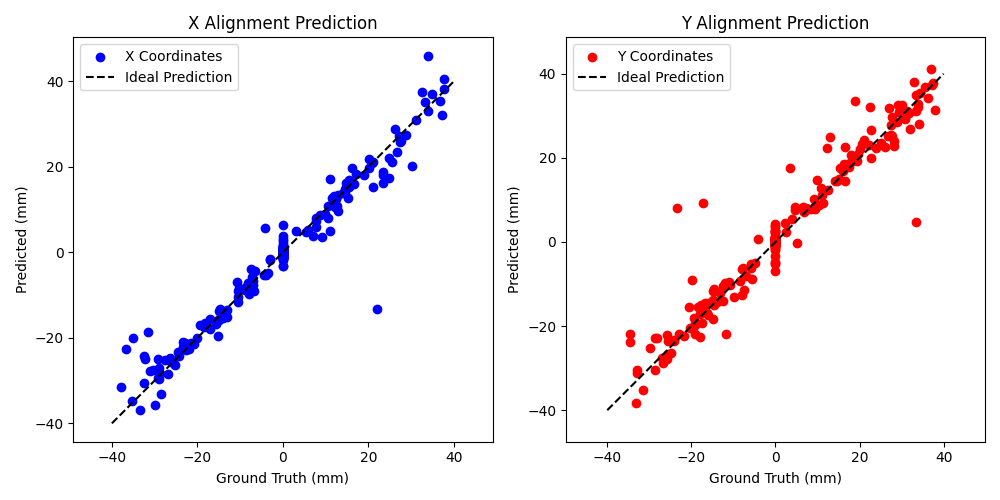

In [88]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
bound = cup.diameter
print(bound)
axs[0].scatter(gt_xs, pred_xs, color="b", label="X Coordinates")
axs[0].plot([-bound, bound], [-bound, bound], 'k--', label="Ideal Prediction")
axs[0].set_aspect('equal', 'datalim')
axs[0].set_title('X Alignment Prediction')
axs[0].set_xlabel('Ground Truth (mm)')
axs[0].set_ylabel('Predicted (mm)')
axs[0].legend()

axs[1].scatter(gt_ys, pred_ys, color="r", label="Y Coordinates")
axs[1].plot([-bound, bound], [-bound, bound], 'k--', label="Ideal Prediction")
axs[1].set_aspect('equal', 'datalim')
axs[1].set_title('Y Alignment Prediction')
axs[1].set_xlabel('Ground Truth (mm)')
axs[1].set_ylabel('Predicted (mm)')
axs[1].legend()

plt.tight_layout()

### Error Histograms
For the x and y components, we plot the error in x and the error in y on a histogram.

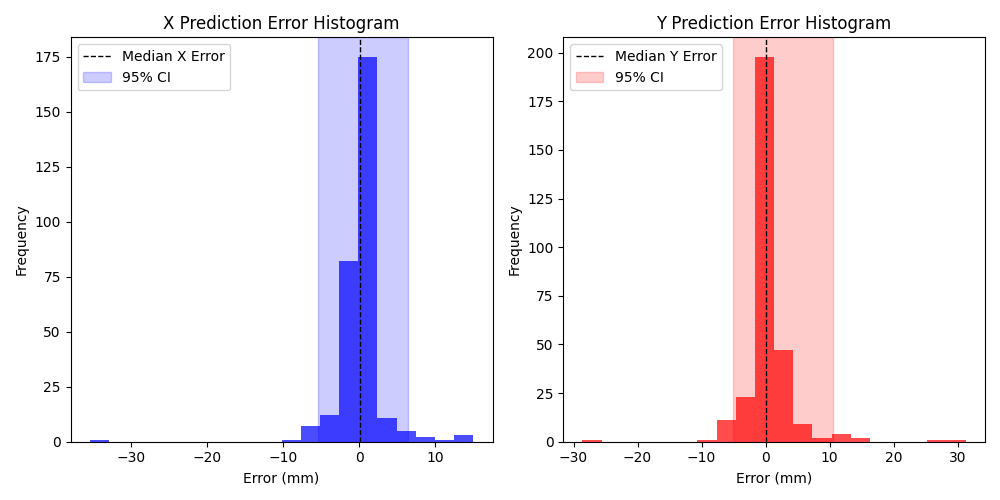

In [89]:
error_x = np.array(pred_xs) - np.array(gt_xs)
error_y = np.array(pred_ys) - np.array(gt_ys)

fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].hist(error_x, bins=20, color='b', alpha=0.7)
axs[0].set_title('X Prediction Error Histogram')
axs[0].set_xlabel('Error (mm)')
axs[0].set_ylabel('Frequency')
axs[0].axvline(x=np.median(error_x), color='k', linestyle='dashed', linewidth=1, label="Median X Error")
axs[0].axvspan(xmin=np.quantile(error_x, 0.025), xmax=np.quantile(error_x, 0.975), color='blue', alpha=0.2, label='95% CI')
axs[0].legend()

axs[1].hist(error_y, bins=20, color='r', alpha=0.7)
axs[1].set_title('Y Prediction Error Histogram')
axs[1].set_xlabel('Error (mm)')
axs[1].set_ylabel('Frequency')
axs[1].axvline(x=np.median(error_y), color='k', linestyle='dashed', linewidth=1, label="Median Y Error")
axs[1].axvspan(xmin=np.quantile(error_y, 0.025), xmax=np.quantile(error_y, 0.975), color='red', alpha=0.2, label='95% CI')
axs[1].legend()
plt.tight_layout()

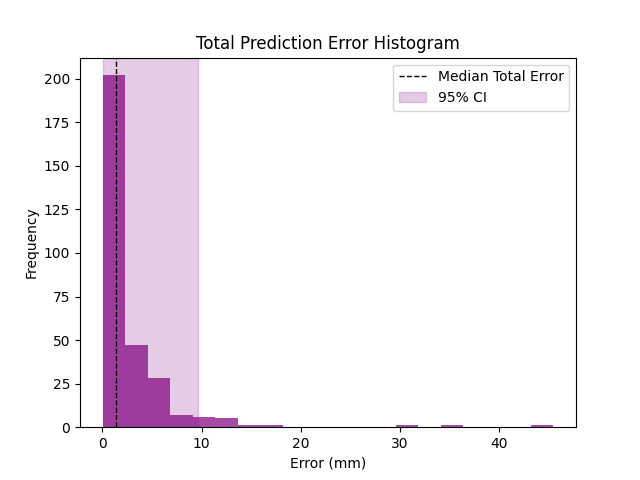

In [90]:
fig, ax = plt.subplots()
error = np.sqrt(error_x**2 + error_y**2)
ax.hist(error, bins=20, color='purple', alpha=0.7)
ax.set_title('Total Prediction Error Histogram')
ax.set_xlabel('Error (mm)')
ax.set_ylabel('Frequency')
ax.axvline(x=np.median(error), color='k', linestyle='dashed', linewidth=1, label="Median Total Error")
ax.axvspan(xmin=np.quantile(error, 0), xmax=np.quantile(error, 0.95), color='purple', alpha=0.2, label='95% CI')
ax.legend()

### Predition Displacement
The prediction outputs an expected necessary position vector for realignment. We compare this to the ground truth requirement and plot the difference between the two. The blue dots represent ground truth, the red dots the predictions, and the black connecting lines represent the error between the two. 

Text(0, 0.5, 'Y Displacement (mm)')

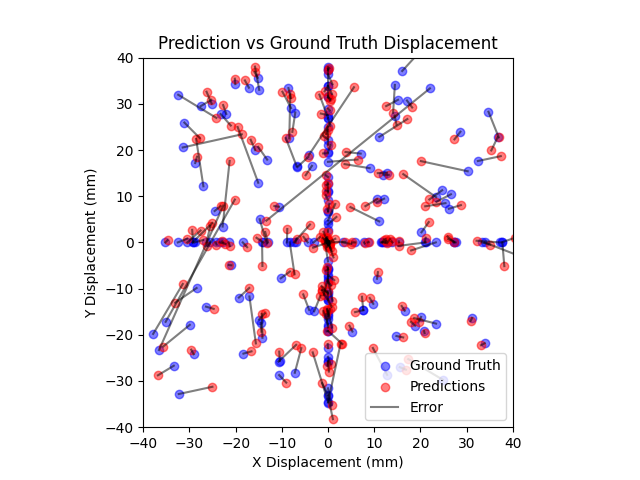

In [91]:
fig, ax = plt.subplots()
ax.scatter(gt_xs, gt_ys, label="Ground Truth", color='blue', alpha=0.5)
ax.scatter(pred_xs, pred_ys, label="Predictions", color='red', alpha=0.5)
ax.plot(np.vstack([gt_xs, pred_xs]), np.vstack([gt_ys, pred_ys]), 'k', alpha=0.5, label="Error")
ax.set_xlim([-bound, bound])
ax.set_ylim([-bound, bound])
ax.set_aspect("equal")
ax.legend(["Ground Truth", "Predictions", "Error"])
ax.set_title("Prediction vs Ground Truth Displacement")
ax.set_xlabel("X Displacement (mm)")
ax.set_ylabel("Y Displacement (mm)")
    

### Losses over Epochs
Plotting the training and validation loss, as well as their ratio.

/tmp/ipykernel_513068/405814364.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


Text(0.5, 1.0, 'Training and Validation Losses')

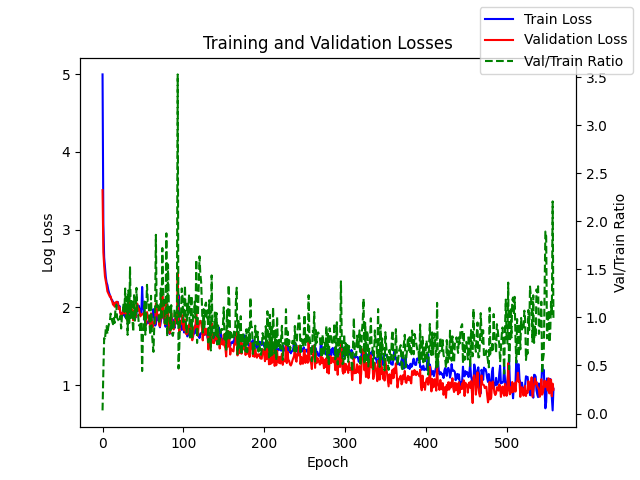

In [92]:
fig, ax = plt.subplots()
ratio_ax = ax.twinx()
ax.plot(np.log10(train_losses), 'b-', label="Train Loss")
ax.plot(np.log10(val_losses), 'r-', label="Validation Loss")
ratio_ax.plot(np.array(val_losses) / np.array(train_losses), 'g--', label="Val/Train Ratio")
ax.set_xlabel("Epoch")
ax.set_ylabel("Log Loss")
ratio_ax.set_ylabel("Val/Train Ratio")
fig.legend()
ax.set_title("Training and Validation Losses")

In [ ]:
# Check if Contraction

# Measure misaligned
# calculate correction
# actuate correction
# calculate correction
# ...
# stop and check if aligned


0.0 0.0
0.08869437 0.046534717

[0. 0.]


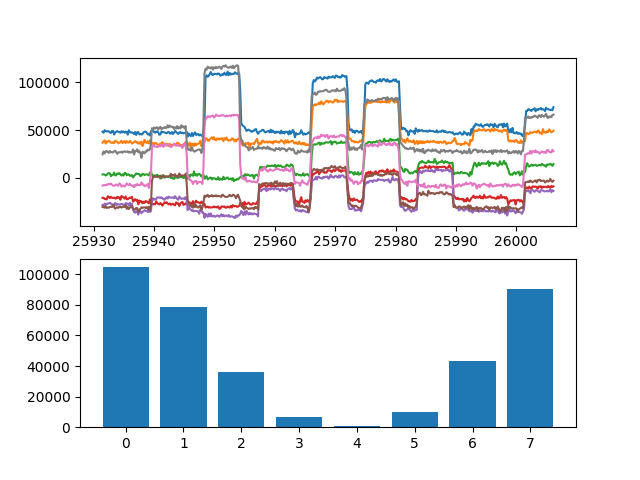

In [148]:
error_order = np.argsort(error)[::-1]
fig, axs = plt.subplots(2)
for idx in error_order[-20:]:
    print(gt_xs[idx], gt_ys[idx])
    print(pred_xs[idx], pred_ys[idx])
    print()
    cap, disp = test_dataset[idx]
    times, cap_series = cap_dataset.get_segment_time_series(val_end + idx)
    # ax.bar(np.arange(len(cap)), cap)
    axs[0].plot(times, cap_series)
    axs[1].bar(np.arange(len(cap)), cap)
    print(disp)
    break